# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．  
なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量

In [5]:
import os
import pandas as pd
import joblib
import numpy as np
from gensim.models import KeyedVectors
import torch       
import torch.nn as nn
ch06_dir = '../ch06'
ch07_dir = '../ch07'
cols = ['TITLE', 'CATEGORY']

In [266]:
train_df = pd.read_table(os.path.join(ch06_dir, 'train.txt'), header=None)
test_df = pd.read_table(os.path.join(ch06_dir, 'test.txt'), header=None)
valid_df = pd.read_table(os.path.join(ch06_dir, 'valid.txt'), header=None)
le = joblib.load(os.path.join(ch06_dir, '50_le.joblib'))
model = KeyedVectors.load_word2vec_format(os.path.join(ch07_dir, 'GoogleNews-vectors-negative300.bin'), binary=True)

In [267]:
train_df.columns = cols
test_df.columns = cols
valid_df.columns = cols

In [119]:
train_df.head()

,TITLE,CATEGORY
0,UPDATE 2-US airlines signal solid demand ahead...,0
1,GLOBAL MARKETS-Subdued Ifo takes M&A shine off...,0
2,Hugh Jackman didn't warn daughter about nude s...,1
3,RPT-US CBO: slightly higher 2014 deficit on lo...,0
4,Did Miley Cyrus Tattoo Her Inner Lip With A Sa...,1


In [211]:
def make_embed(row):
    title = row['TITLE']
    embed_matrix = [model[w]  if w in model.vocab else np.zeros(shape=(model.vector_size,)) for w in title.split(' ')]
    return np.mean(np.array(embed_matrix), axis=0)

In [268]:
for df,s in zip([train_df, test_df, valid_df], ['train', 'test', 'valid']):
    X = df.apply(make_embed, axis=1)
    X = np.array(list(X.values))
#     y = df.apply(make_y, axis=1)
    y = np.array(list(df['CATEGORY'].values))
    joblib.dump(X,f'X_{s}.joblib')
    joblib.dump(y,f'y_{s}.joblib')

## 71. 単層ニューラルネットワークによる予測


In [217]:
%%bash
# pip install torch 
# pip install torchvision

You are using pip version 18.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [245]:
INPUT_FEATURES = 300
OUTPUT_NEURONS = 4

In [246]:
activation = torch.nn.Softmax()

In [259]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(
            INPUT_FEATURES,   
            OUTPUT_NEURONS)

    def forward(self, input):
        # フォワードパスを定義
        output = activation(self.layer1(input))  
        return output

In [260]:
model = NeuralNetwork()

In [261]:
X_train = joblib.load('X_train.joblib')
X_train = torch.from_numpy(X_train.astype(np.float32)).clone()

In [262]:
y_pred = model(X_train[:4])
print(y_pred)

tensor([[0.2420, 0.2436, 0.2433, 0.2711],
        [0.2424, 0.2418, 0.2464, 0.2694],
        [0.2296, 0.2553, 0.2397, 0.2753],
        [0.2399, 0.2413, 0.2597, 0.2591]], grad_fn=<SoftmaxBackward>)


/Users/shota.kikuchi/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


## 72. 損失と勾配の計算

In [107]:
def import_dataset(mode='train', cuda=False):
    
    X = joblib.load(f'X_{mode}.joblib')
    X = torch.from_numpy(X.astype(np.float32)).clone()
    y = joblib.load(f'y_{mode}.joblib')
    y = torch.from_numpy(y.astype(np.int64)).clone()
    
    if not cuda:
        return X, y
    
    return X.to('cuda:0'), y.to('cuda:0')

In [7]:
X_train, y_train = import_dataset()

In [8]:
X = X_train[:4]
y = y_train[:4]

In [9]:
net = nn.Linear(X.size()[1], 4)

In [10]:
y_pred = net(X)
print(y_pred.shape)

torch.Size([4, 4])


In [11]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(y_pred, y)
print(loss)
err = loss.backward()
print(net.weight.grad.data.norm())

tensor(1.4252, grad_fn=<NllLossBackward>)
tensor(0.6406)


## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [16]:
from torch import nn, optim

In [68]:
X_train, y_train = import_dataset()

net = nn.Linear(X.size()[1],4)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [69]:
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    y_train_pred = net(X_train)
    loss = loss_fn(y_train_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss)

In [70]:
print(net.state_dict()['weight'])

tensor([[-0.0003,  0.0511, -0.0092,  ...,  0.0331,  0.0520, -0.0014],
        [-0.0445,  0.0087,  0.0257,  ..., -0.0489, -0.0323, -0.0414],
        [-0.0493, -0.0539, -0.0290,  ...,  0.0252, -0.0489,  0.0437],
        [ 0.0470, -0.0072, -0.0077,  ...,  0.0265,  0.0322, -0.0213]])


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [71]:
X_test, y_test = import_dataset(mode='test')

In [72]:
_, y_train_pred = torch.max(net(X_train), axis=1)
_, y_test_pred = torch.max(net(X_test), axis=1)
train_acc = (y_train_pred == y_train).sum().item() / len(y_train)
test_acc = (y_test_pred == y_test).sum().item() / len(y_test)
print(f'train acc: {train_acc}')
print(f'test acc: {test_acc}')

train acc: 0.5694340329835083
test acc: 0.5524737631184408


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [73]:
from matplotlib import pyplot as plt

In [84]:
def calc_acc(y_pred, y):
    _, y_pred = torch.max(y_pred, axis=1)
    return (y_pred == y).sum().item() / len(y)

In [85]:
X_train, y_train = import_dataset()
X_test, y_test = import_dataset(mode='test')

net = nn.Linear(X.size()[1],4)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [95]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(100):
    optimizer.zero_grad()
    y_train_pred = net(X_train)
    train_loss = loss_fn(y_train_pred, y_train)
    train_loss.backward()
    optimizer.step()
    
    # record loss and accuracy
    y_test_pred = net(X_test)
    test_loss = loss_fn(y_test_pred, y_test)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accs.append(calc_acc(y_train_pred, y_train))
    test_accs.append(calc_acc(y_test_pred, y_test))

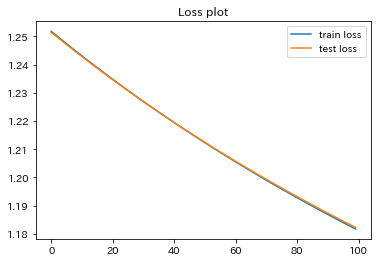

In [96]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.title('Loss plot')
plt.show()

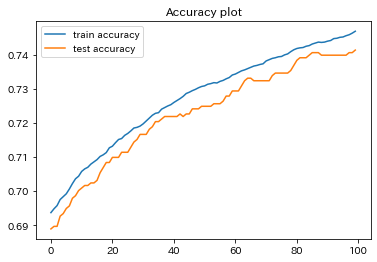

In [97]:
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.legend()
plt.title('Accuracy plot')
plt.show()

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [100]:
import joblib

In [99]:
checkpoints_dir = 'checkpoints-76'
os.makedirs(checkpoints_dir, exist_ok=True)

In [101]:
for X_train, y_train = import_dataset()

net = nn.Linear(X.size()[1],4)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    y_train_pred = net(X_train)
    train_loss = loss_fn(y_train_pred, y_train)
    train_loss.backward()
    optimizer.step()
    joblib.dump(net.state_dict(), f'{checkpoints_dir}/state_dict_{epoch}.joblib')

/Users/shota.kikuchi/.pyenv/versions/3.6.8/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [103]:
from torch.utils.data import TensorDataset, DataLoader
import time

In [109]:
X_train, y_train = import_dataset()
dataset = TensorDataset(X_train, y_train)

net = nn.Linear(X.size()[1],4)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
epochs = 100

batch_size = [64, 128]
for bs in batch_size[:3]:
    loader = DataLoader(dataset, batch_size=bs, shuffle=True)
    start_time = time.time()
    
    for epoch in range(epochs):
        for xx, yy in loader:
            y_train_pred = net(xx)
            train_loss = loss_fn(y_train_pred, yy)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
    end_time = time.time()
    elapsed_time = start_time - end_time
    print(f'batch size {bs} total elapsed time: {elapsed_time}, epoch average elapsed time: {elapsed_time/epochs}')

KeyboardInterrupt: 

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [110]:
X_train, y_train = import_dataset(cuda=True)
dataset = TensorDataset(X_train, y_train)

net = nn.Linear(X.size()[1],4)
net = net.to('cuda:0')
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
epochs = 100

batch_size = [1, 2,4, 8, 16]
for bs in batch_size[:3]:
    loader = DataLoader(dataset, batch_size=bs, shuffle=True)
    start_time = time.time()
    
    for epoch in range(epochs):
        for xx, yy in loader:
            y_train_pred = net(xx)
            train_loss = loss_fn(y_train_pred, yy)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
    end_time = time.time()
    elapsed_time = start_time - end_time
    print(f'batch size {bs} total elapsed time: {elapsed_time}, epoch average elapsed time: {elapsed_time/epochs}')

AssertionError: Torch not compiled with CUDA enabled

## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [112]:
X_train, y_train = import_dataset()
# use cuda
# X_train, y_train = import_dataset(cuda=True)
dataset = TensorDataset(X_train, y_train)

net = nn.Sequential(
    nn.Linear(X_train.size(1),128),
    nn.PReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 32),
    nn.PReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, 4)
)
# use cuda
# net = net.to('cuda:0')
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
epochs = 100

batch_size = [64, 128]
for bs in batch_size[:3]:
    loader = DataLoader(dataset, batch_size=bs, shuffle=True)
    start_time = time.time()
    
    for epoch in range(epochs):
        for xx, yy in loader:
            y_train_pred = net(xx)
            train_loss = loss_fn(y_train_pred, yy)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
    end_time = time.time()
    elapsed_time = start_time - end_time
    print(f'batch size {bs} total elapsed time: {elapsed_time}, epoch average elapsed time: {elapsed_time/epochs}')

KeyboardInterrupt: 